# 等离子体电子声波（理论公式）：Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双kappa运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_\sigma = \frac{n_\sigma}{\sqrt{2\pi T (\kappa_\sigma-3/2)}} \frac{\Gamma(\kappa_\sigma)}{\Gamma(\kappa_\sigma-1/2)} \left( 1+\frac{1}{\kappa_\sigma-3/2} \frac{v^2}{2T} \right)^{-\kappa_\sigma} $$
                          
- 色散关系
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
其中$\xi_\sigma = \frac{\omega}{k \theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
上述色散关系将允许两支波，一支类似于fast electrons的Langmuir波（LW）；另一支类似于slow electrons的Acoustic波（KW，由两组分不同$\kappa$导致）

- $Z_\kappa$级数展开和渐近展开
$$ Re[Z_\kappa(\xi<<1)] = -\frac{\sqrt{\pi}}{\kappa^{3/2} \Gamma(\kappa-1/2)} \sum_{n=0}^\infty \frac{(-1)^n \Gamma(\kappa+n+3/2)}{\Gamma(n+3/2)}\left( \frac{\xi^2}{\kappa} \right)^{n+\frac{1}{2}}$$
$$ Re[Z_\kappa(\xi>>1)] = -\frac{\sqrt{\pi}}{\kappa^{3/2} \cos(\kappa \pi) \Gamma(\kappa-1/2)} \sum_{n=0}^\infty (-1)^n \left(\frac{\xi^2}{\kappa} \right)^{n+\frac{1}{2}} \left[ \frac{\Gamma(n+1/2)}{\Gamma(n+1/2-\kappa)} + \frac{\sin(\kappa \pi) \Gamma(\kappa+n+1)}{\Gamma(n+1)} \left( \frac{\xi^2}{\kappa} \right)^{\kappa+\frac{1}{2}} \right]$$

- 色散关系的解析表达式
$$ \omega^2 = \omega_s^2 \frac{1 + 2A k^2 \lambda_s^2 +2 A \lambda_s^2/\lambda_{\kappa f}^2}{1+1/(k^2 \lambda_{\kappa f}^2)} $$
其中
$$ A = \frac{3\kappa_s}{2\kappa_s-3} + 2\kappa_s \tan(\kappa_s\pi)\frac{\sqrt{\pi} \Gamma(\kappa_s+1)}{\Gamma(\kappa_s-1/2)}$$
$$ \lambda_{\kappa f} = \sqrt{\frac{2 \kappa_f}{2\kappa_f-1}} \lambda_f$$
$$\lambda_{s,f}^2 = \frac{v_{s,f}^2}{2 \omega_{s,f}^2} = \frac{\epsilon_0 T}{n_{s,f} e^2} $$

## 函数定义

In [2]:
# exact PDR
def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1)
    z = 0.5*(1+1j*zeta/np.sqrt(kappa))
    hyp = sp.hyp2f1(1,2*kappa+2,kappa+2,z)
    return fac*hyp

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_f**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
    return [r.real,r.imag]
# PDR expansion
def zs_ex(zeta,kappa,order):
    fac = -np.pi**0.5/kappa**1.5/np.cos(kappa*np.pi)/sp.gamma(kappa-0.5)
    z = kappa/zeta**2
    s = 0
    for n in np.arange(order):
        g = (-1)**n*z**(n+0.5)
        s += g*( sp.gamma(n+0.5)/sp.gamma(n+0.5-kappa) + np.sin(kappa*np.pi)*sp.gamma(kappa+1+n)/sp.gamma(n+1)*z**(kappa+0.5) )
    return 1-0.5/kappa+zeta*fac*s

def zf_ex(zeta):
    return r

def zf_ex_kappa(zeta,kappa,order):
    ex = 0
    for n in np.arange(order):
        ex += np.sqrt(np.pi)/kappa**2/sp.gamma(kappa-0.5)*(-1/kappa)**n*sp.gamma(1.5+n+kappa)/sp.gamma(n+1.5)*zeta**(2*n+2)
    return 1 - 0.5/kappa -ex

def PDR_exs(w,k,order_s):
    zeta_s = w/k/v_s
    zeta_f = w/k/v_f
    zs = zs_ex(zeta_s,kappa_s,order_s)
#     zf = zf_ex_kappa(zeta_f,10,10)
    zf = 1+zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f).real
    return 1 + 2*(wp_s/k/v_s)**2*zs + 1/(k*l_f)**2 * zf

def PDR_analytic(k):
    A = 2*kappa_s*np.sqrt(np.pi)*sp.gamma(kappa_s+1)/sp.gamma(kappa_s-0.5)*np.tan(kappa_s*np.pi)+3*kappa_s/(2*kappa_s-3)
    return A*k**2*v_s**2 + wp_s / np.sqrt(1+1/(k*l_f)**2)

# set and print parameters
def PrintParas():
    paras_table = PrettyTable(['T='+str(T),'n','kappa','wp','theta','lambda_D'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4)])
    paras_table.add_row(['f',n_f,'-',round(wp_f,4),round(v_f,4),round(l_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    v_s = np.sqrt((2*kappa_s-3)/kappa_s*T/m)
    v_f = np.sqrt(2*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,v_s,v_f

### 精确解、展开解和解析解的比较


In [79]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 10

n_s = 0.5
kappa_s = 1.505

n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

+------+-----+-------+--------+--------+----------+
| T=10 |  n  | kappa |   wp   | theta  | lambda_D |
+------+-----+-------+--------+--------+----------+
|  s   | 0.5 | 1.505 | 0.7071 | 0.2578 |  4.4721  |
|  f   | 0.5 |   -   | 0.7071 | 4.4721 |  4.4721  |
+------+-----+-------+--------+--------+----------+


In [80]:
wr_guess = 0.1
wi_guess = -1

In [81]:
k_list = np.linspace(0.1,0.8,num=200)
# 搜索a=0时解方程初值
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_guess,wi_guess],method='hybr')
print('k = ',k_list[0])
print(s0.success,s0.x)
wr_guess_int = s0.x[0]
wi_guess_int = s0.x[1]

k =  0.1
True [ 0.23662081 -0.12130061]


- zs展开与精确解

In [82]:
wr_guess = wr_guess_int
wi_guess = wi_guess_int

wr_list = np.array([])
wi_list = np.array([])
wr_ex5_list = np.array([])
wr_ex4_list = np.array([])
wr_ex3_list = np.array([])

for k_each in tqdm(k_list,position=0,leave=True):
    s1 = op.root(lambda w:PDR_2KE(w,k_each),[wr_guess,wi_guess])
    if s1.success==True:
        wr_guess = round(s1.x[0],4)
        wi_guess = round(s1.x[1],4)
        wr_list = np.append(wr_list,s1.x[0])
        wi_list = np.append(wi_list,s1.x[1])
    else:
        wr_list = np.append(wr_list,np.nan)
        wi_list = np.append(wi_list,np.nan)
        
    s5 = op.root(lambda w:PDR_exs(w,k_each,5),wr_guess,method='hybr')
    if s5.success==True:
        wr_ex5_list = np.append(wr_ex5_list,s5.x[0])
    else:
        wr_ex5_list = np.append(wr_ex5_list,np.nan)
        
    s4 = op.root(lambda w:PDR_exs(w,k_each,4),wr_guess,method='hybr')
    if s4.success==True:
        wr_ex4_list = np.append(wr_ex4_list,s4.x[0])
    else:
        wr_ex4_list = np.append(wr_ex4_list,np.nan)
        
    s3 = op.root(lambda w:PDR_exs(w,k_each,3),wr_guess,method='hybr')
    if s3.success==True:
        wr_ex3_list = np.append(wr_ex3_list,s3.x[0])
    else:
        wr_ex3_list = np.append(wr_ex3_list,np.nan)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 182.81it/s]


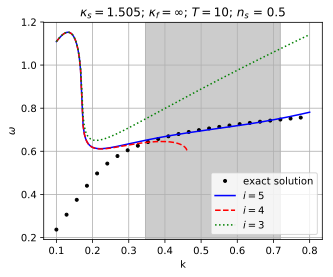

In [83]:
fig = plt.figure(figsize=(5,4))
ax1 = plt.subplot()
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
b_kw = wi_list/abs(wr_list/2/np.pi)
ax1.plot(k_list[::8],wr_list[::8],'.',color='black',label='exact solution')
ax1.plot(k_list,wr_ex5_list,'-',color='blue',label='$i=5$')
ax1.plot(k_list,wr_ex4_list,'--',color='red',label='$i=4$')
ax1.plot(k_list,wr_ex3_list,':',color='green',label='$i=3$')
ax1.axvspan(k_list[b_kw>-1][0],k_list[b_kw>-1][-1],color='black',alpha=0.2)
plt.title(r"$\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$"+"; $T = $"+str(T)+"; $n_s$ = "+str(n_s))
ax1.grid()
ax1.legend(loc='lower right')
# plt.savefig('./figs/fig_expan_exact.eps',bbox_inches = 'tight')
plt.show()

- 解析解和精确解

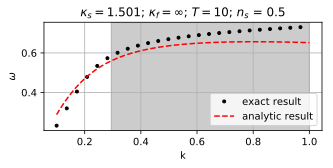

In [63]:
fig = plt.figure(figsize=(5,2))
ax1 = plt.subplot()
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
b_kw = wi_list/abs(wr_list/2/np.pi)
ax1.plot(k_list[::8],wr_list[::8],'.',color='black',label='exact result')
ax1.axvspan(k_list[b_kw>-1][0],k_list[b_kw>-1][-1],color='black',alpha=0.2)
ax1.plot(k_list,PDR_analytic(k_list),'--',color='red',label='analytic result')
plt.title(r"$\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$"+"; $T = $"+str(T)+"; $n_s$ = "+str(n_s))
ax1.grid()
ax1.legend(loc='lower right')
# plt.savefig('./figs/fig_analytic_exact_a.eps',bbox_inches = 'tight')
plt.show()

-0.02480826037972394


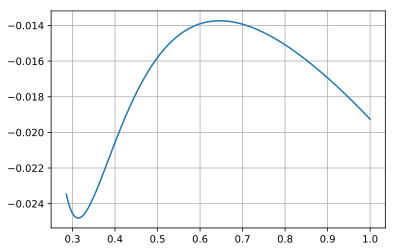

In [56]:
rel_err = (PDR_analytic(k_list)[b_kw>-1]-wr_list[b_kw>-1])/wr_list[b_kw>-1]
print(rel_err.min())
plt.plot(k_list[b_kw>-1],rel_err)
plt.grid()
plt.show()

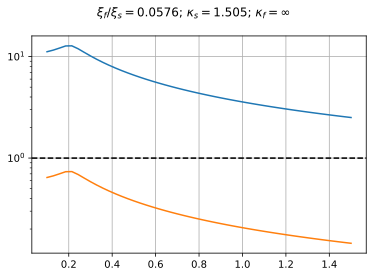

In [156]:
zeta_s_list = wr_list/k_list/v_s
zeta_f_list = wr_list/k_list/v_f
plt.plot(k_list,zeta_s_list)
plt.plot(k_list,zeta_f_list)
plt.axhline(1,linestyle='--',color='black')
plt.yscale('log')
plt.suptitle(r"$\xi_f/\xi_s = $"+str(round(v_s/v_f,4))+"; $\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$")
plt.grid()

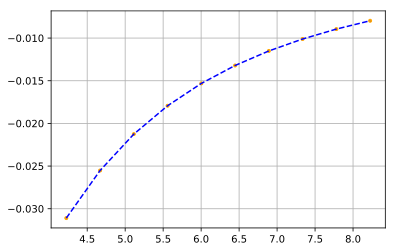

In [11]:
def zs_ex_mace_re(zeta,kappa,order):
    a = -0.5/zeta**2
    s = 0
    for n in np.arange(order):
        kfactor = 1.0
        for nn in np.arange(n):
            kfactor *= (2*kappa-2*nn-3)
        s += sp.factorial2(2*n+1)*kappa**(n)/kfactor/zeta**(2*n)
    return a*s

def zs_ex_mace_im(zeta,kappa):
    fac = -1j*np.sqrt(np.pi)*sp.gamma(kappa+1)/kappa**1.5/np.cos(kappa*np.pi)/sp.gamma(kappa-0.5)
    z = -1j*zeta/np.sqrt(kappa)
    r1 = (z-1)**(-kappa-1)
    r2 = (z+1)**(-kappa-1)
    return (zeta*fac*r1*r2).real


zeta_list = np.linspace(np.sqrt(kappa_s)+3,np.sqrt(kappa_s)+7,num=10)
ze_list = []
for zeta in zeta_list:
    ze_list.append((1-0.5/kappa_s+zeta*dispersion_function(zeta,kappa_s).real))

plt.plot(zeta_list,ze_list,'.',color='orange')
plt.plot(zeta_list,zs_ex(zeta_list,kappa_s,10),'--',color='blue')
# plt.plot(zeta_list,zs_ex_mace_re(zeta_list,kappa_s,10),'--',color='purple')
plt.grid()
plt.show()

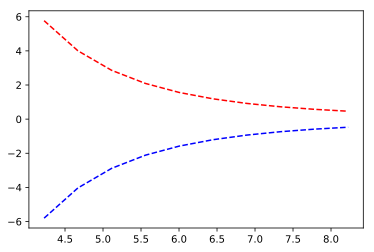

In [12]:
plt.plot(zeta_list,zs_ex_mace_re(zeta_list,kappa_s,10),'--',color='blue')
plt.plot(zeta_list,zs_ex_mace_im(zeta_list,kappa_s),'--',color='red')